This notebook builds some data visualization prototypes. The idea being that before we commit to building fully-featured and expensive visualizations, we first need to verify that the signal we want to communicate is actually clear and apparent. What we see here also influences decisions we make in the design of the final visualizations.

First we import the data and the necessary libraries, and perform certain processing steps that we developed in `Preliminary Exploration`.

## Prep work

In [1]:
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

frontages = gpd.read_file('../../data/processed/frontages.json').set_index('frontage_id')
blocks = gpd.read_file('../../data/processed/blocks.json').set_index('block_id')
buildings = gpd.read_file('../../data/processed/buildings.json').set_index('building_id')
blockfaces = gpd.read_file('../../data/processed/blockfaces.json').set_index('blockface_id')

trash = gpd.read_file('../../data/processed/trash.json').set_index('id')
trash = trash.assign(
    time=pd.to_datetime(trash.time)
)
filter_dates = (trash
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n.count()
 .where(lambda v: v < 100)
 .dropna()
 .index
)
trash = trash[~trash.time.map(lambda v: v.replace(hour=0, minute=0, second=0)).isin(filter_dates)]
trash = trash.drop(columns=['isSponsored', 'isValidated', 'likes'])
trash = trash[trash['time'] >= pd.to_datetime('October 1 2018')]

In the previous notebook, we neglected to deal with another problem in the dataset: points which are located far from the actual survey zone, indicating points that were collected outside of the survey zone. There are handful of such points in the dataset.

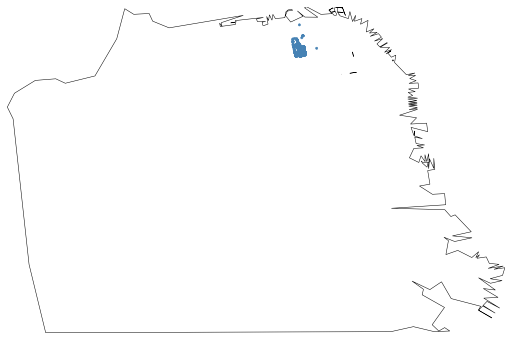

In [2]:
import geoplot as gplt
sf = gpd.read_file('https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/san-francisco.geojson')
ax = gplt.pointplot(trash)
gplt.polyplot(sf, ax=ax)

There are a few ways of filtering these points out. A simple way is to buffer the `frontages` geometry (turning it into a `Polygon`) and perform a spatial join on the points, leaving out those that lie outside of the buffer area. 

Since GPS error is uniformally randomly distributed (the blocks are all equally built up so there is not significantly more signal scatter on any one block), this is a safe operation to do, because the points we drop will be totally random.

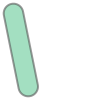

In [3]:
inclusion_zone = frontages.unary_union.buffer(0.0005)
inclusion_zone

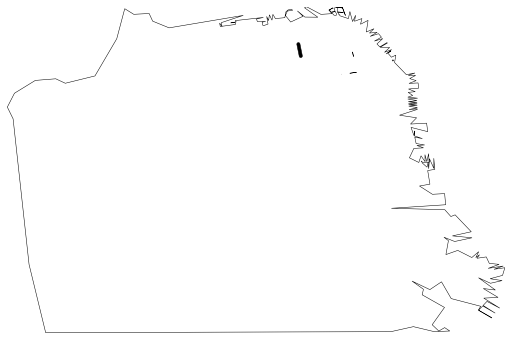

In [4]:
ax = gplt.polyplot(gpd.GeoDataFrame([], geometry=[inclusion_zone]), facecolor='black')
gplt.polyplot(sf, ax=ax)

In [5]:
%%time


trash = (
    gpd.sjoin(
        trash, gpd.GeoDataFrame([], geometry=[frontages.unary_union.buffer(0.0005)]),
        how="inner", op='intersects'
    )
)

/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


CPU times: user 6.39 s, sys: 139 ms, total: 6.53 s
Wall time: 6.65 s


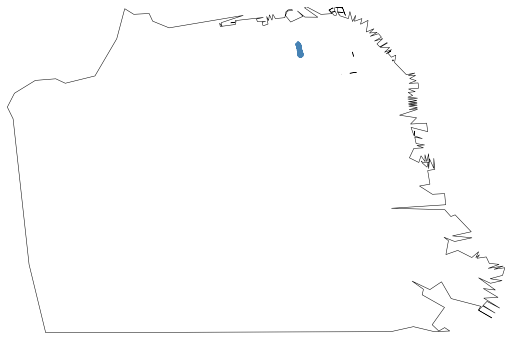

In [6]:
ax = gplt.pointplot(trash)
gplt.polyplot(sf, ax=ax)

Next we snap points to the line using the `spaghetti` library.

In [7]:
import spaghetti as spgh

In [8]:
%%time

net = spgh.Network(in_data=frontages)
net.snapobservations(trash, 'trash')
updated_trash_points = spgh.element_as_gdf(net, pp_name='trash', snapped=True)

CPU times: user 43.9 s, sys: 123 ms, total: 44 s
Wall time: 44.1 s


We look at point snap distances to verify that everything is kosher.

Text(0.5, 1.0, 'Snapped Trash Points by Distance Moved')

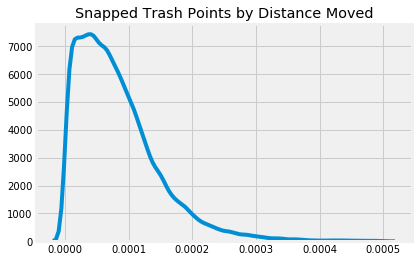

In [9]:
import seaborn as sns

ax = sns.kdeplot(
    (trash.reset_index().geometry.distance(updated_trash_points.geometry)),
)
ax.set_title('Snapped Trash Points by Distance Moved')

[0.0001 degrees latitude is about 10 meters](https://en.wikipedia.org/wiki/Decimal_degrees#Precision) (exact distance depends on latitude and longtiude). So it looks like points were moved about five meters, or 16 feet, on average, [which is reasonable](https://gis.stackexchange.com/questions/43617/what-is-the-maximum-theoretical-accuracy-of-gps).

## First visual idea: two-sided violin plot

A two-sided violin plot provides an overview of the variance of trash levels down the blocks and between either side of the blocks in the dataset. This requires converting point locations to distances from the origin point of our (linear) survey segment. We choose the top right point as the origin point:

/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/site-packages/geoplot/geoplot.py:633: UserWarning: Attempting to set identical left == right == -122.422525 results in singular transformations; automatically expanding.
  ax.set_xlim((xmin, xmax))
/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/site-packages/geoplot/geoplot.py:634: UserWarning: Attempting to set identical bottom == top == 37.799694 results in singular transformations; automatically expanding.
  ax.set_ylim((ymin, ymax))


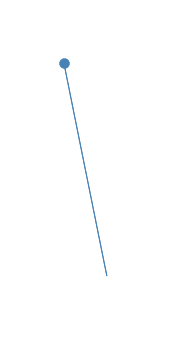

In [10]:
from shapely.geometry import Point
ax = gplt.pointplot(gpd.GeoDataFrame([], geometry=[Point(*frontages.total_bounds[[0, 3]])]), s=100)
gplt.sankey(frontages, ax=ax, extent=frontages.buffer(0.001).total_bounds)

Of course these distances will naively be in terms of degrees latitude/longitude.

In [11]:
updated_trash_points.geometry.distance(Point(*frontages.total_bounds[[0, 3]])).describe()

count    92257.000000
mean         0.002311
std          0.001019
min          0.000000
25%          0.001550
50%          0.002529
75%          0.003206
max          0.003825
dtype: float64

We need to convert these distances to real, human-readable values (e.g. meters). A [quick distance calculation](http://boulter.com/gps/distance/?from=-122.422525%2C++37.799694&to=-122.421525%2C+++37.799694&units=k) shows that 0.001 coordinate degrees in San Francisco is roughly 0.11 kilometers, or 110 meters, or 360 feet, or 0.068 miles. We'll normalize to feet because we're filthy Americans.

In [12]:
trash_point_distances = (
    updated_trash_points.geometry.distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
)

Text(0.5, 1.0, 'Trash Locations Along Street')

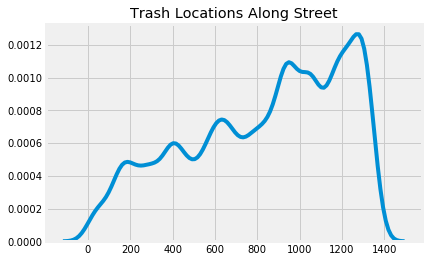

In [13]:
ax = sns.kdeplot(trash_point_distances)
ax.set_title('Trash Locations Along Street')

The normalized data has interesting patterns to it.

For one thing, it is constantly increasing the closer we get to Broadway. This is in line with out expectations and exactly what we want to demonstrate in our visualization!

For another thing, It has four major equally spaced dips, and one minor dip. Perhaps that these are due to the roads that appear at the block intersections, which are not subject to cleanup (streets are cleaned by street sweepers; Rubbish Runs only target sidewalks). To see whether this is true or not, let's grab those points...

In [14]:
street_points = blocks.iloc[[0, 1, 5, 6]].geometry.map(lambda geom: Point(geom.bounds[0], geom.bounds[1]))
net.snapobservations(street_points, 'street_points')
updated_street_points = spgh.element_as_gdf(net, pp_name='street_points', snapped=True)

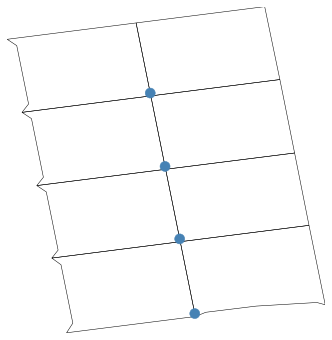

In [15]:
ax = gplt.pointplot(updated_street_points, s=100)
gplt.polyplot(blocks, ax=ax)

...and overlay their distances on top of the `kdeplot`:

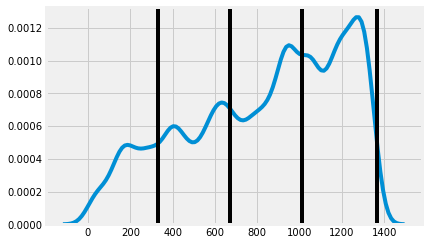

In [16]:
ax = sns.kdeplot(trash_point_distances)

for v in (
    updated_street_points
    .distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
):
    ax.axvline(v, c='black')

Hmm. There is some alignment, but it doesn't seem like the only effect that's causing this.

Let's test the other hypothesis: that the side of the street that the trash was located on matters. The only indication we have of which side of the street a piece of trash was located on really is its (unsnapped) GPS coordinate, which of course can veer onto the other side of the street due to GPS inaccuracy.

According to [an environmental review document](https://web.archive.org/web/20151003134858/https://www.sfmta.com/sites/default/files/agendaitems/2015/3-3-15%20Item%2012%20Polk%20St%20%20Environmental%20Review_0.pdf) written by SFMTA, the Polk Street roadway is 44 feet 9 inches in width in the segment covered by the survey zone, with 12 foot sidewalks on either side. Assuming pessimistically that pickups occur at the edge of the curb, that would mean that the inaccuracy of the GPS coordinate would need to exceed 22 feet 4.5 inches to be misclassified onto the wrong side.

The block edge is on the street centerline, and one standard deviation of GPS coordinate inaccuracy is 4 meters or 13 feet in either direction ([source](https://gis.stackexchange.com/questions/43617/what-is-the-maximum-theoretical-accuracy-of-gps)). Assuming this value is accurate on Polk Street (there is only a few floors worth of vertical build-up, and the users are using recent-model iPhone or Android phones with good antenna hardware, so it's reasonable to assume it is):

**The misclassification rate for trash pickups appearing to occur on one side of the street centerline whilst actually being from other side of the street centerline is less than 5%**

That's an acceptable level of statistical noise. If this math checks out, we should be able to trust the result we get when we divide the trash points into "left of Polk" and "right of Polk".

The hypothesis being that there will be a very different trash profile on either side of the street, due to differences in the businesses located on those blocks.

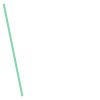

In [17]:
from shapely.geometry import LineString
ls = LineString([Point(frontages.total_bounds[[0, 3]]), Point(frontages.total_bounds[[2, 1]])])
ls

A simple point algorithm lets us distinguish between points left of the street centerline and points right of it.

In [18]:
A = Point(frontages.total_bounds[[0, 3]])
B = Point(frontages.total_bounds[[2, 1]])

def lr(p):
    return 'right' if (B.x - A.x) * (p.y - A.y) - (B.y - A.y) * (p.x - A.x) > 0 else 'left'

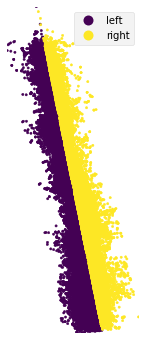

In [19]:
gplt.pointplot(trash.assign(side=trash.geometry.map(lr)), hue='side', legend=True)

In [20]:
trash = trash.assign(side=trash.geometry.map(lr))

In [21]:
len(trash.query('side == "left"')), len(trash.query('side == "right"'))

(60322, 31935)

There are indeed *way* more trash pickups on the left side of the street than on the right! Why? The hypothesis is that the type of business is meaningful. For example every bar in the dataset is located on the left side of the survey zone, whereas the right side is more residential.

In [22]:
trash = trash.assign(distance=trash_point_distances.values)

Text(0.5, 1.0, 'Trash Location Distribution Functions by Street Side')

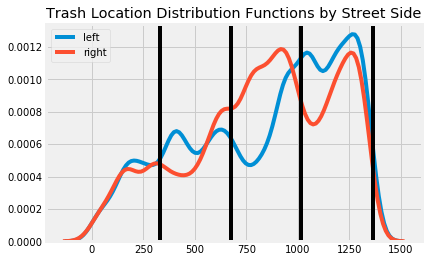

In [23]:
ax = sns.kdeplot(trash.query('side == "left"')['distance'].rename('left'))
sns.kdeplot(trash.query('side == "right"')['distance'].rename('right'), ax=ax)
for v in (
    updated_street_points
    .distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
):
    ax.axvline(v, c='black')
ax.set_title('Trash Location Distribution Functions by Street Side')

The pattern in distribution is also meaningfully different. The trash on the left side of Polk in the survey zone is more concentrated at the south end of the survey zone, whereas the right side of the street is consistently high in the middle to end parts of the distribution. Again the street intersections are added for context.

Text(0.5, 0.98, 'Trash Distribution Binned Histograms, Left and Right')

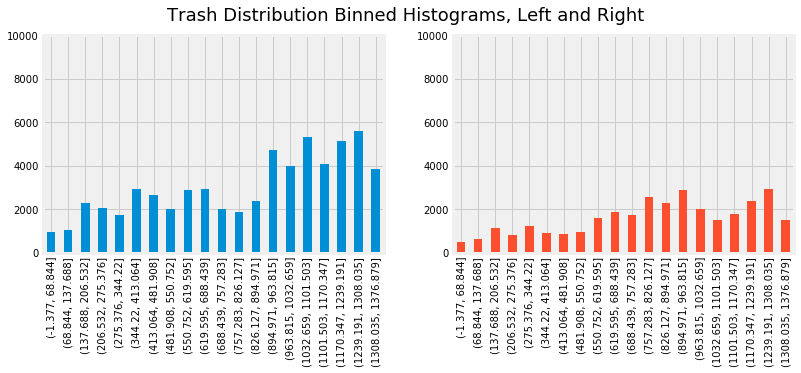

In [24]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
pd.cut(trash.query('side == "left"')['distance'], 20).value_counts().sort_index(ascending=True).plot.bar(
    ax=axarr[0]
)
axarr[0].set_ylim((0, 10000))
pd.cut(trash.query('side == "right"')['distance'], 20).value_counts().sort_index(ascending=True).plot.bar(
    ax=axarr[1], color=sns.color_palette()[1]
)
axarr[1].set_ylim((0, 10000))
plt.suptitle('Trash Distribution Binned Histograms, Left and Right', fontsize=18)

OLD BELOW

Text(0.5, 0.98, 'Trash Distribution Binned Histograms, Left and Right')

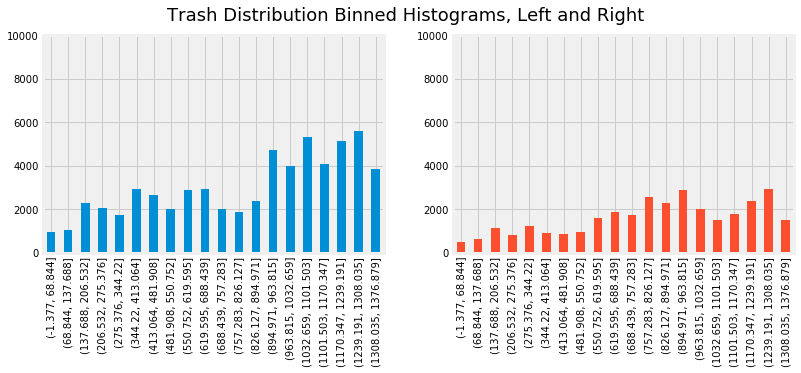

In [25]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
pd.cut(trash.query('side == "left"')['distance'], 20).value_counts().sort_index(ascending=True).plot.bar(
    ax=axarr[0]
)
axarr[0].set_ylim((0, 10000))
pd.cut(trash.query('side == "right"')['distance'], 20).value_counts().sort_index(ascending=True).plot.bar(
    ax=axarr[1], color=sns.color_palette()[1]
)
axarr[1].set_ylim((0, 10000))
plt.suptitle('Trash Distribution Binned Histograms, Left and Right', fontsize=18)

By splitting the data into bins and pair-plotting bar charts showing the cumulative number of trash observations in those bins, we can see in even more dramatic fashion the nature of the difference between the trash distributions on either side of the street.

Ultimately the visualization that we would like to build is a combination of these previous two plots into a street-aligned violinplot with geospatial context. It looks like there's plenty of support for this.

## Second visual idea: drill-down view on cigarette disposal units

The city installed a set of cigarette disposal bins on or around January 15, 2019. Rubbish separetely set one up as a short-term experiment at a similar time. The question is: did these have a significant effect on cigarette trash volumes?

There are a few aspects of this we need to look into. The nearest before Rubbish run occurred on January 12, 2019. The nearest after Rubbish run occurred on January 17, 2019. Installation of cigarette trash collectors should result in some mixture of *distribution* differences with *volumetric* differences. But due to data noise, this may not necessarily be easy to tease out.

In [26]:
city_cig_disposal_units = gpd.GeoSeries([
    Point(-122.42212, 37.79716),
    Point(-122.42231, 37.79788),
    Point(-122.42193, 37.79602),
    Point(-122.42246, 37.79886)
])
net = spgh.Network(in_data=frontages)
net.snapobservations(city_cig_disposal_units, 'disposals')
city_cig_disposal_units = spgh.element_as_gdf(net, pp_name='disposals', snapped=True)

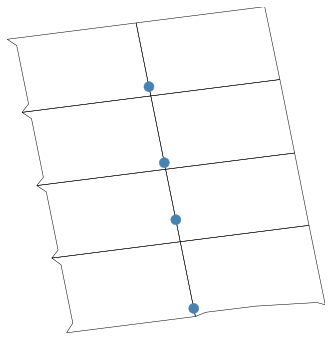

In [27]:
ax = gplt.pointplot(city_cig_disposal_units, s=100)
gplt.polyplot(blocks, ax=ax)

In [28]:
jan_12_pickups = trash[
    trash.time.map(lambda v: v.replace(hour=0, minute=0, second=0)) == pd.to_datetime('2019-01-12')
]
jan_17_pickups = trash[
    trash.time.map(lambda v: v.replace(hour=0, minute=0, second=0)) == pd.to_datetime('2019-01-17')
]

In [29]:
jan_12_tobacco_pickups = jan_12_pickups.query('type == "tobacco"')
jan_17_tobacco_pickups = jan_17_pickups.query('type == "tobacco"')

print(
    f"{len(jan_12_pickups)} pickups on January 12, of which {len(jan_12_tobacco_pickups)} "
    f"({np.round(len(jan_12_tobacco_pickups) / len(jan_12_pickups), 2) * 10**2}%) were cigs."
)
print(
    f"{len(jan_17_pickups)} pickups on January 17, of which {len(jan_17_tobacco_pickups)} "
    f"({np.round(len(jan_17_tobacco_pickups) / len(jan_17_pickups), 2) * 10**2}%) were cigs."
)

906 pickups on January 12, of which 383 (42.0%) were cigs.
690 pickups on January 17, of which 253 (37.0%) were cigs.


The effect on cigarette trash between January 12 and January 17 does not look statistically significant.

Text(0.5, 1.0, 'Distribution of Trash w/ and w/o Cig Disposal Units')

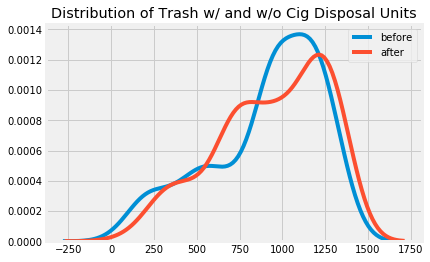

In [30]:
ax = sns.kdeplot(
    trash[trash.time.map(
        lambda v: v.replace(hour=0, minute=0, second=0)
    ) == pd.to_datetime('2019-01-12')].query('type == "tobacco"')['distance'].rename('before')
)

sns.kdeplot(
    trash[trash.time.map(
        lambda v: v.replace(hour=0, minute=0, second=0)
    ) == pd.to_datetime('2019-01-17')].query('type == "tobacco"')['distance'].rename('after'),
    ax=ax
)
ax.set_title("Distribution of Trash w/ and w/o Cig Disposal Units")

The shape of the trash also looks similar-ish.

What if we look at more data?

In [31]:
tobacco_volumes_by_day = (trash
 .pipe(lambda df: df.assign(time=df['time'].map(lambda v: v.replace(hour=0, minute=0, second=0))))
 .assign(n=0)
 .query('type == "tobacco"')
 .set_index('time')
 .resample('D')
 .n
 .count()
 .where(lambda v: v > 0)
 .dropna()
 .astype(int)
)

all_trash_volumes_by_day = (trash
 .pipe(lambda df: df.assign(time=df['time'].map(lambda v: v.replace(hour=0, minute=0, second=0))))
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n
 .count()
 .where(lambda v: v > 0)
 .dropna()
 .astype(int)
)

Text(0.5, 1.0, 'Cigarette Distribution Function')

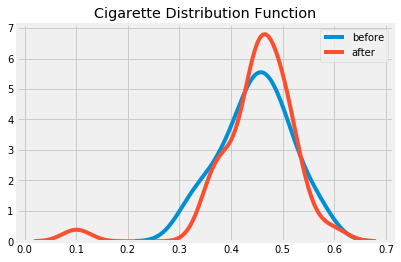

In [32]:
ax = sns.kdeplot(
    (tobacco_volumes_by_day / all_trash_volumes_by_day)[:pd.to_datetime('2019-01-15')].rename('before')
)
sns.kdeplot(
    (tobacco_volumes_by_day / all_trash_volumes_by_day)[pd.to_datetime('2019-01-15'):].rename('after'),
    ax=ax
)

ax.set_title('Cigarette Distribution Function')

This plot shows [a kernel density estimate of] the cigarette distribution function before and after the installation of the cigarette disposal units. There is small difference in the distribution of the cigarattes, but it's hard to say that this is a significant effect.

(0, 1)

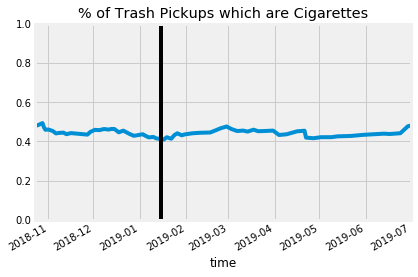

In [33]:
ax = (tobacco_volumes_by_day / all_trash_volumes_by_day).rolling(10).mean().dropna().plot.line(
    title='% of Trash Pickups which are Cigarettes'
)
ax.axvline(pd.to_datetime('2019-01-15'), color='black')
ax.set_ylim((0, 1))

A rolling mean of trash pickups doesn't appear to show a difference in the percentage of trash on the street which is cigarettes. If cigarette volume was truly reduced by the installation of the cigarette disposal units, we'd expect that fact to show up in this plot, because there would be no effect of the installation of the units on the other types of trash, thus reducing the overall percentage of cigarettes.

A rolling mean was used here to smooth out seasonal variability and overall data variance.

It is possible that the cigarette disposal installation did in fact have a statistical effect on the data, but countervailing factors that kicked in at around the same time caused a strong effect in the opposite direction, nullifying the reduction.

Looking into what some surveys have to say about cigarette litter I find the following ([source](https://www.kab.org/sites/default/files/LitterinAmerica_FactSheet_CigaretteButtLitter.pdf)):

> * 38% of cigarette butt littering is associated with the physical environment, including the number of ash receptacles. The presence of ash receptacles, either as stand-alone, or integrated into a trash can, correlates with lower rates of cigarette butt littering.
> * For every additional ash receptacle, the littering rate for cigarette butts decreases by 9%.
> * At the time of improper disposal, litterers were an average of 31 feet from an ash receptacle. While trash
receptacles are widespread (at 91% of observed sites), ash receptacles are less common, with only 47% of observed sites having an ash only or ash/trash receptacle.

It's possible that by accounting for more seasonal and other effects in the data, we may find the result that we're looking for, e.g. a significant effect of the cigarette disposal units on litter volumes.

## Detour: trash volume question

The preliminary explorations notebook pointed out an interesting and important but unexplained artifact in the data: the far greater number of trash pickups that occurred in the earlier months then in later months. We skipped over this but it's still bothering me.

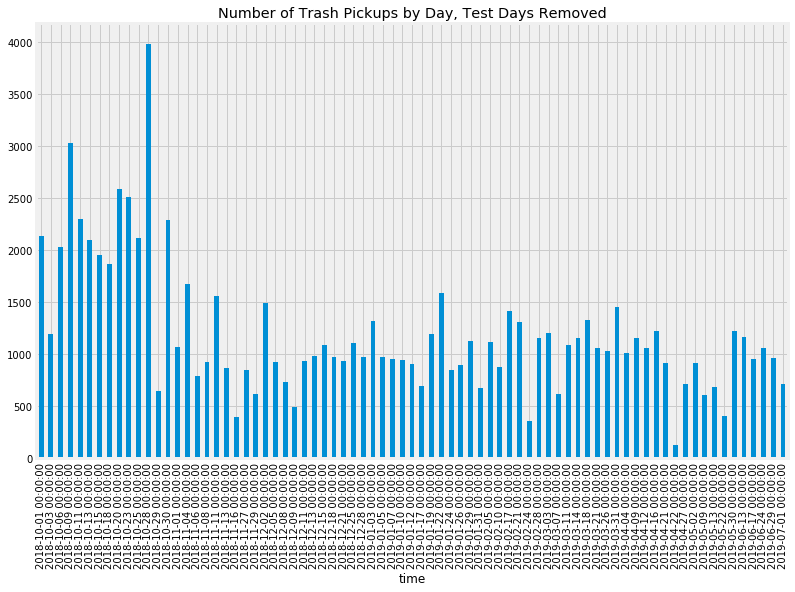

In [34]:
(trash
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n.count()
 .where(lambda v: v > 0)
 .dropna()
 .plot.bar(figsize=(12, 8), title='Number of Trash Pickups by Day, Test Days Removed')
)

Is this perhaps due to the use of the `totalNumberOfItemsTagged` columns? This seems unlikely but may be worth testing...

In [35]:
(pd.Series(index=trash[trash['totalNumberOfItemsTagged'].astype(int) > 1]
           .time.values)
 .replace(np.nan, 0)
 .resample('M')
 .count())

2018-10-31    704
2018-11-30    132
2018-12-31     36
2019-01-31     55
2019-02-28     65
2019-03-31     47
2019-04-30     14
2019-05-31      4
2019-06-30     27
2019-07-31      1
Freq: M, dtype: int64

Actually the opposite is true, this column saw 20x as much use in the first month in our partition of the dataset as it does now.

Is this due to cleanup days earlier in the history of the runs being more sporadic than later ones? After all, the longer the break between runs, the more trash there is on the street to pick up when the run finally occurs. We can check for this effect by checking the average number of trash items per day between runs.

In [36]:
normalized_tobacco_volumes = (
 pd.DataFrame(tobacco_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(tobacco_volumes_by_day.index[1:] - tobacco_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
)

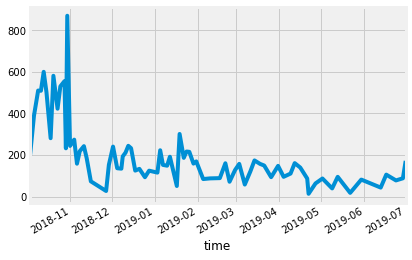

In [37]:
pd.DataFrame(normalized_tobacco_volumes, columns=['daily_count']).daily_count.plot.line()

But this too was higher to begin with than later. Time to ask the team.

...team doesn't know either. It's a mystery!

## Returning to cigarette disposal units

Do we see any interesting effects if we look *just* around the locations of the disposal units, and *just* on the side of the street on which they were installed (all units were installed on the left side)?

Replotting our earlier plot of cigarette trash distributions before and after this disposal units, this time with the locations of the units overplotted on top:

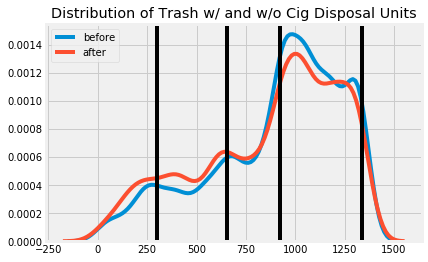

In [38]:
cigarette_disposal_units_point_distances = (
    city_cig_disposal_units.distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
)
city_cig_disposal_units = city_cig_disposal_units.assign(distance=cigarette_disposal_units_point_distances)

ax = sns.kdeplot(
    trash[trash.time.map(
        lambda v: v.replace(hour=0, minute=0, second=0)
    ) <= pd.to_datetime('2019-01-12')].query('type == "tobacco"').query('side == "left"')\
    ['distance'].rename('before')
)

sns.kdeplot(
    trash[trash.time.map(
        lambda v: v.replace(hour=0, minute=0, second=0)
    ) >= pd.to_datetime('2019-01-17')].query('type == "tobacco"').query('side == "left"')\
    ['distance'].rename('after'),
    ax=ax
)
ax.set_title("Distribution of Trash w/ and w/o Cig Disposal Units")

for val in city_cig_disposal_units['distance']:
    ax.axvline(val, color='black')

Text(0.5, 0.98, 'Cigarette Trash Distributions, Before and After, Absolute Magnitudes')

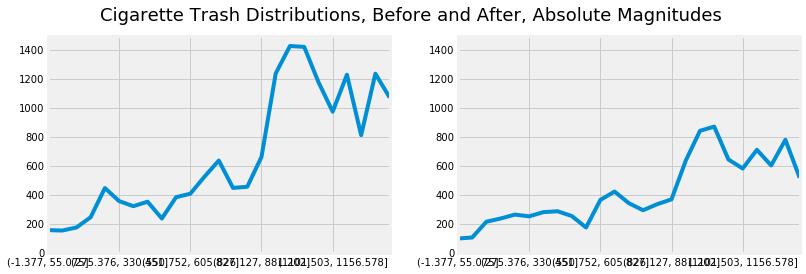

In [39]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
(
    trash[
        trash.time.map(
            lambda v: v.replace(hour=0, minute=0, second=0)) >= pd.to_datetime('2019-01-17')
    ].query('type == "tobacco"')
    .query('side == "left"')\
    ['distance']
    .rename('after')
    .pipe(lambda srs: pd.cut(srs, 25))
    .value_counts()
    .sort_index()
    .plot.line(ax=axarr[1])
)

(
    trash[
        trash.time.map(
            lambda v: v.replace(hour=0, minute=0, second=0)) < pd.to_datetime('2019-01-17')
    ].query('type == "tobacco"')
    .query('side == "left"')\
    ['distance']
    .rename('after')
    .pipe(lambda srs: pd.cut(srs, 25))
    .value_counts()
    .sort_index()
    .plot.line(ax=axarr[0])
)
axarr[0].set_ylim(0, 1500)
axarr[1].set_ylim(0, 1500)
plt.suptitle('Cigarette Trash Distributions, Before and After, Absolute Magnitudes', fontsize=18)

Though the decrease in overall volume is once again *very* visually apparent (and is again an around-the-board change), the distribution on the right is just a squished function of the one on the left, e.g. the cigarette disposals have not affected the distribution pattern at all.

Text(0.5, 1.0, 'Cigarette Distribution Function Near Disposal Unit')

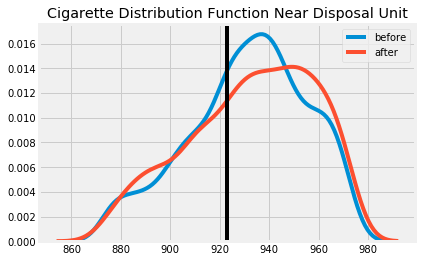

In [40]:
bounds = next(zip(cigarette_disposal_units_point_distances - 50, cigarette_disposal_units_point_distances + 50))

ax = sns.kdeplot(
    trash[
        trash.time.map(
            lambda v: v.replace(hour=0, minute=0, second=0)
        ) < pd.to_datetime('2019-01-17')
    ].query('type == "tobacco"')
    .query('side == "left"')
    .pipe(lambda df: df[((df['distance'] < bounds[1]) & (df['distance'] > bounds[0]))])\
    ['distance']
    .rename('before')
)

sns.kdeplot(
    trash[
        trash.time.map(
            lambda v: v.replace(hour=0, minute=0, second=0)
        ) >= pd.to_datetime('2019-01-17')
    ].query('type == "tobacco"')
    .query('side == "left"')
    .pipe(lambda df: df[((df['distance'] < bounds[1]) & (df['distance'] > bounds[0]))])\
    ['distance']
    .rename('after'),
    ax=ax
)
ax.axvline(cigarette_disposal_units_point_distances.values[0], color='black')
ax.set_title('Cigarette Distribution Function Near Disposal Unit')

Some small change in shape in distribution, but not in the outcome. Ultimately, we cannot find evidence that the cigarette disposal units changed the trash game.

## Third visual idea: overall drop in trash volume

We want to communicate to the user that the volume of trash in the survey zone has dropped around the board (as we've seen in the previous analyses) precipitiously.

In order to get a clearer look at this effect, we are going to use the full set of data, e.g. including the segment of the data from September and October 2018 when the categorical mapping of the trash types were different. We've excluded this early segment of the pickups so far because it's an irreconsible difference in ontology, but it's important/appropriate to include this segment in any "overall drop" graphics.

In [41]:
%%time

trash_all = gpd.read_file('../../data/processed/trash.json').set_index('id')
trash_all = trash_all.assign(
    time=pd.to_datetime(trash_all.time)
)
filter_dates = (trash_all
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n.count()
 .where(lambda v: v < 100)
 .dropna()
 .index
)
trash_all = trash_all[~trash_all.time.map(lambda v: v.replace(hour=0, minute=0, second=0)).isin(filter_dates)]
trash_all_volumes_by_day = (trash_all
 .pipe(lambda df: df.assign(time=df['time'].map(lambda v: v.replace(hour=0, minute=0, second=0))))
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n
 .count()
 .where(lambda v: v > 0)
 .dropna()
 .astype(int)
)
del trash_all

CPU times: user 22.3 s, sys: 725 ms, total: 23 s
Wall time: 23.2 s


(0, 2500)

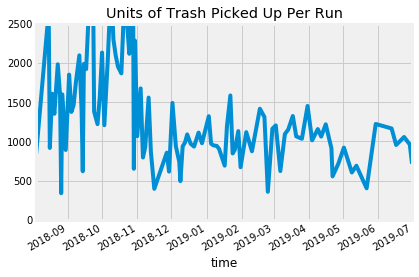

In [42]:
ax = trash_all_volumes_by_day.plot.line(
    title='Units of Trash Picked Up Per Run'
)
ax.set_ylim((0, 2500))

This estimation is very noisy, we can smooth it out by taking a rolling mean.

(0, 2500)

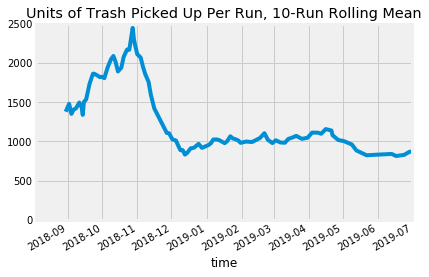

In [43]:
ax = trash_all_volumes_by_day.rolling(10).mean().plot.line(
    title='Units of Trash Picked Up Per Run, 10-Run Rolling Mean'
)
ax.set_ylim((0, 2500))

This distribution could well be modelled by a three-spline linear function: a short segment at 1500 in October and November 2018, up to 2000 at the end of the year, then down precipitiously to 1000 throughout 2019.

We can clean this view up a few ways. First, let's normalize on days, removing the smoothing in the process. 

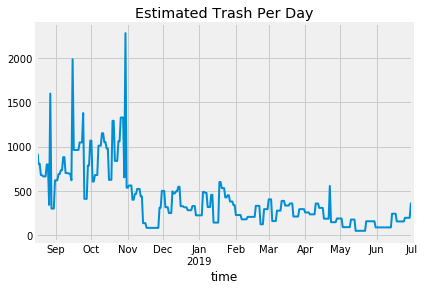

In [44]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .plot.line(
     title='Estimated Trash Per Day',
     linewidth=2
 )
)

Next, let's look at the weekend effect. Runs are performed on pretty random days of the week, and there is a lot of intra-day noise and variability, so it's not possible to isolate trash "dropped on a weekend" from "trash dropped on a weekday". We can only isolate an average number of trash dropped per day between each of the variably sized and spaced rubbish runs.

Nevertheless, if there is a strong difference between the volume of trash dropped on a weekday, and the volume of trawsh dropped on a weekend, even this average number should exhibit some difference in distribution.

We will consider only trash pickups since January 1 2019, in order to exclude the effect of the drop in overall volume on display in e.g. the plot above.

Text(0.5, 1.0, 'Estimated Trash Per Day, Weekends versus Weekdays')

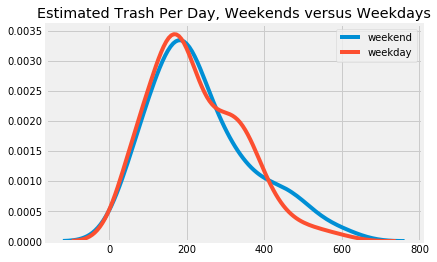

In [45]:
trash_since_january =\
    all_trash_volumes_by_day.where(all_trash_volumes_by_day.index >= pd.to_datetime('January 1, 2019')).dropna()

ax = sns.kdeplot(pd.DataFrame(trash_since_january)
 .iloc[1:]
 .assign(delta_days=(trash_since_january.index[1:] - trash_since_january.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs.where(pd.Series(srs.index.values).dt.dayofweek.isin([5, 6]).values))
 .dropna()
 .rename('weekend')
)

sns.kdeplot(pd.DataFrame(trash_since_january)
 .iloc[1:]
 .assign(delta_days=(trash_since_january.index[1:] - trash_since_january.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs.where(~pd.Series(srs.index.values).dt.dayofweek.isin([5, 6]).values))
 .dropna()
 .rename('weekday'),
 ax=ax
)
ax.set_title('Estimated Trash Per Day, Weekends versus Weekdays')

**TODO**: this is actually a `kde` estimation of the distribution function, which does *not* say anything about the total volume. So this doesn't actually validate anything!

<br/><br/>

<s>
The distributions are very similar, so we find no evidence that weekends are more or less trashy than weekdays. This doesn't necessarily mean that there *is* no difference; it just means that the difference, if it exists, is small enough to escape our (admittedly course-grained) ability to assess it.

So there's no statistically significant weekend effect we can isolate.
</s>

Next, let's remove one-off outliers: holidays and one-off events like SantaCon that had strong temporary effects on trash patterns. Analyzing these outliers in isolatation is a separate section of this project.

First, let's look at outliers in the dataset.

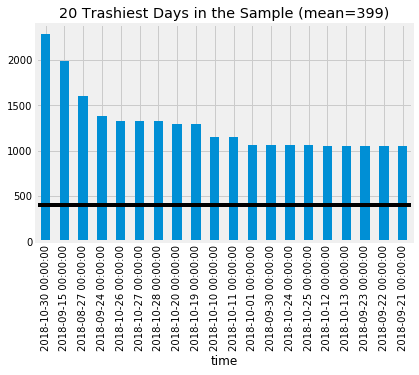

In [46]:
# trash_all_volumes_by_day is the DataFrame containing all data
# all_trash_volumes_by_day is the DataFrame containing data clipped from 2018-10-01 forward
# confusing. sorry about that!
mean_trash = (pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .mean())

ax = (pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .sort_values(ascending=False)
 .head(20)
 .plot.bar(title=f'20 Trashiest Days in the Sample (mean={np.round(mean_trash).astype(int)})')
)
ax.axhline(mean_trash, color='black')

This plot demonstrates the coarseness of our estimating method: bars with the same height are for contiguous groups of days in between rubbish runs, and there are probably actually one or maybe two super-bad days there that just got smoothed over the rest of the intermediate period.

The top day in the dataset is the day before Halloween. Rubbish runs occurred on the 29th, the 30th, and the 1st. Interestingly enough the 30th was the "bad day". The 31st doesn't even make the top 20...

In [47]:
trash_all_volumes_by_day[trash_all_volumes_by_day.index > pd.to_datetime('October 20, 2018')].head(10)

time
2018-10-23    2512
2018-10-25    2118
2018-10-28    3988
2018-10-29     650
2018-10-30    2286
2018-11-01    1067
2018-11-04    1676
2018-11-06     794
2018-11-08     925
2018-11-11    1559
Name: n, dtype: int64

September 15 is a mystery. So is August 27th. We're not making much headway this way unfortunately, so let's switch tracks to the least garbage-y days.

In [48]:
trash_all_volumes_by_day[trash_all_volumes_by_day.index > pd.to_datetime('September 10, 2018')].head(10)

time
2018-09-11    2098
2018-09-13    1384
2018-09-14     618
2018-09-15    1990
2018-09-17    1922
2018-09-20    2886
2018-09-23    3140
2018-09-24    1380
2018-09-27    1220
2018-09-29    1570
Name: n, dtype: int64

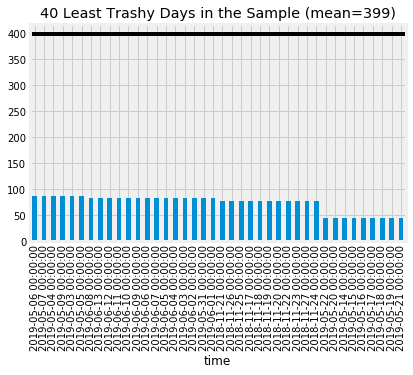

In [49]:
ax = (pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .sort_values(ascending=False)
 .tail(40)
 .plot.bar(title=f'40 Least Trashy Days in the Sample (mean={np.round(mean_trash).astype(int)})')
)
ax.axhline(mean_trash, color='black')

One of these that is obvious is the Camp Fires, which occurred around those days in November and reduced foot activity in the city to near absolute minimum due to the [poor quality of the air](https://en.wikipedia.org/wiki/Camp_Fire_(2018)#/media/File:Air_quality_in_Bay_Area_during_Camp_Fire..png). The June stretch includes the San Francisco heat wave, which saw temperatures approaching to hitting 100 degrees.

It is unclear what happened in May. Is this perhaps a data error?

In [50]:
may_cleanups = trash_all_volumes_by_day.index[pd.Series(trash_all_volumes_by_day.index).dt.month == 5]
may_cleanups

DatetimeIndex(['2019-05-02', '2019-05-09', '2019-05-13', '2019-05-22',
               '2019-05-30'],
              dtype='datetime64[ns]', name='time', freq=None)

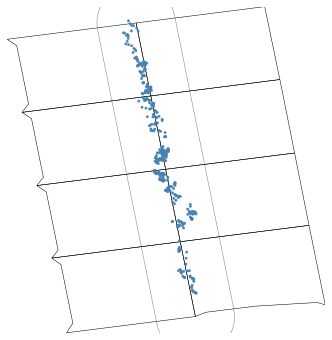

In [51]:
ax = gplt.pointplot(trash
 .pipe(lambda df: df.assign(time=df['time'].map(lambda v: v.replace(hour=0, minute=0, second=0))))
 .query('time == @may_cleanups[3]')
)
gplt.polyplot(gpd.GeoDataFrame([], geometry=[inclusion_zone]), edgecolor='gray', ax=ax)
gplt.polyplot(blocks, ax=ax)

Nope, the point distribution is well within the boundaries of the geometries. The likeliest explanation is that there was some sort of independent cleanup effort that had occurred immediately prior to the run, because it is impossible to believe that anything would have reduced trash volume in the city more dramatically than the fires or the heat wave did.

Next, let's look at some days which the team flagged as being interesting which we haven't already covered above.

In [52]:
trash_all_volumes_by_day[trash_all_volumes_by_day.index >= pd.to_datetime('December 5, 2018')].head()

time
2018-12-05    937
2018-12-08    738
2018-12-09    492
2018-12-11    937
2018-12-13    984
Name: n, dtype: int64

SantaCon on December 8th (the night of, so it showed up in the next-day December 9th data) was flagged as being particularly bad. And indeed, we see that it did indeed seemingly roughly double the amount of litter deposited on the street...but that effect persisted even *after* the next cleanup occurred.

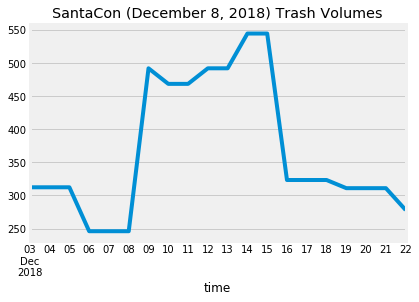

In [53]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[srs.index >= pd.to_datetime('December 3, 2018')])
 .head(20)
 .plot.line(title='SantaCon (December 8, 2018) Trash Volumes')
)

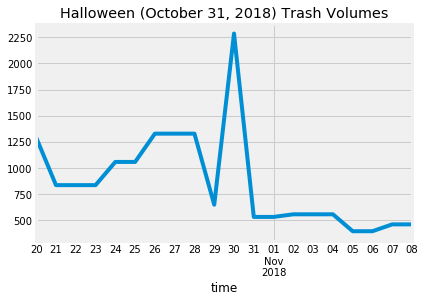

In [54]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[srs.index >= pd.to_datetime('October 20, 2018')])
 .head(20)
 .plot.line(title='Halloween (October 31, 2018) Trash Volumes')
)

Halloween, yeah, worst day for trash in the city.

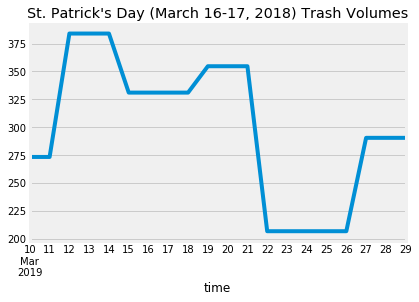

In [55]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[srs.index >= pd.to_datetime('March 10, 2019')])
 .head(20)
 .plot.line(title='St. Patrick\'s Day (March 16-17, 2018) Trash Volumes')
)

St. Patrick's Day didn't show up.

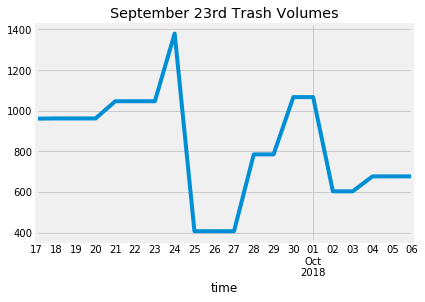

In [56]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[srs.index >= pd.to_datetime('September 17, 2018')])
 .head(20)
 .plot.line(title='September 23rd Trash Volumes')
)

Something happened on September 23rd which was notable; team doesn't know what it was exactly. This shows up.

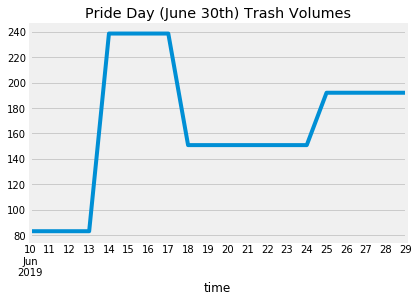

In [57]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[srs.index >= pd.to_datetime('June 10, 2019')])
 .head(20)
 .plot.line(title='Pride Day (June 30th) Trash Volumes')
)

Pride Day occurred on June 30, right at the edge of the dataset. It doesn't show up sigificantly, and the team said that it "seemed cleaner than most of the rest of the holidays".

Overall, it appears that there is not anything we can do to "clean up" our understanding of the mean values, unfortunately.

Let's now return to the question of how best to show how the volume of trash on Polk has changed over time. One way of showing how stark of a difference there is between the start of the runs and the end is to fit it to a normal:

Text(0.5, 1.0, 'Trash Distribution Functions')

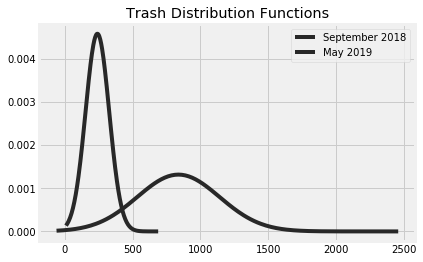

In [58]:
from scipy.stats import norm

sns.set_color_codes()
ax = sns.distplot(
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[(pd.Series(srs.index).dt.month == 9).values])
),
    fit=norm, kde=False, hist=False, label='September 2018'
)
sns.distplot(
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .pipe(lambda srs: srs[(pd.Series(srs.index).dt.month == 4).values])
),
    fit=norm, kde=False, hist=False, label='May 2019',
    ax=ax
)
ax.legend()
ax.set_title("Trash Distribution Functions")

The average day in May featured just 250 or so items of trash on the street. The average day in September, 750. That's a 66% decrease in the amount of trash on the street, on average!

We chose these two months because they are the two months which have the fewest outliers (aside from September 23rd, which was minor).

Can we can communicate this information in a more information-dense manner?

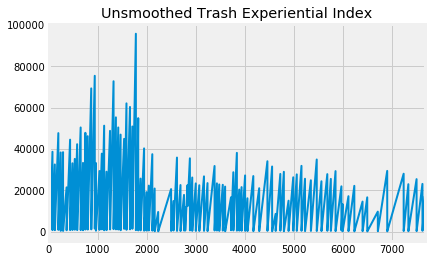

In [59]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('H')
 .fillna(method='bfill')
 .rename('estimated_trash_dropped')
 .to_frame()
 .reset_index()
 .groupby('estimated_trash_dropped')
 .agg({'estimated_trash_dropped': np.cumsum})
 .squeeze()
 .plot.line(linewidth=2, title='Unsmoothed Trash Experiential Index')
)

This plot shows how much trash you would see on the street if you were to step out on a certain day.

Sadly, it's too visually coarse to be usable. The problem is that we can only safely project trash dropped on the street in a linear, day-to-day basis, and even this requires a bit of imagination and "hand waving". Sadly that is soo small a sampling rate to allow for the kind of smooth curves I hoped I could get with this sort of a plot.

A rough cut at rounding using hourly rollups follows below, but it didn't help almost at all.

In [60]:
trash_pickups_per_hour = (trash
 .pipe(lambda df: df.assign(time=df['time'].map(lambda v: v.replace(minute=0, second=0))))
 .assign(n=0)
 .set_index('time')
 .resample('H')
 .n
 .count()
 .pipe(lambda srs: srs[srs.index >= pd.to_datetime('2018-10-03 00:00:00')])
)

In [61]:
trash_dropped_per_hour = (pd.DataFrame(all_trash_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(all_trash_volumes_by_day.index[1:] - all_trash_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .map(lambda v: v / 24)
 .resample('H')
 .fillna(method='bfill')
)

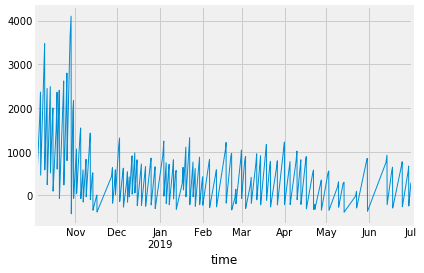

In [62]:
(trash_dropped_per_hour - trash_pickups_per_hour).iloc[16:].cumsum().plot.line(linewidth=1)

Ultimately a simple array of normal distributions may work best.

[Text(0, 0, '0'),
 Text(0, 0, '500'),
 Text(0, 0, '1000'),
 Text(0, 0, '1500'),
 Text(0, 0, '2000'),
 Text(0, 0, '2500')]

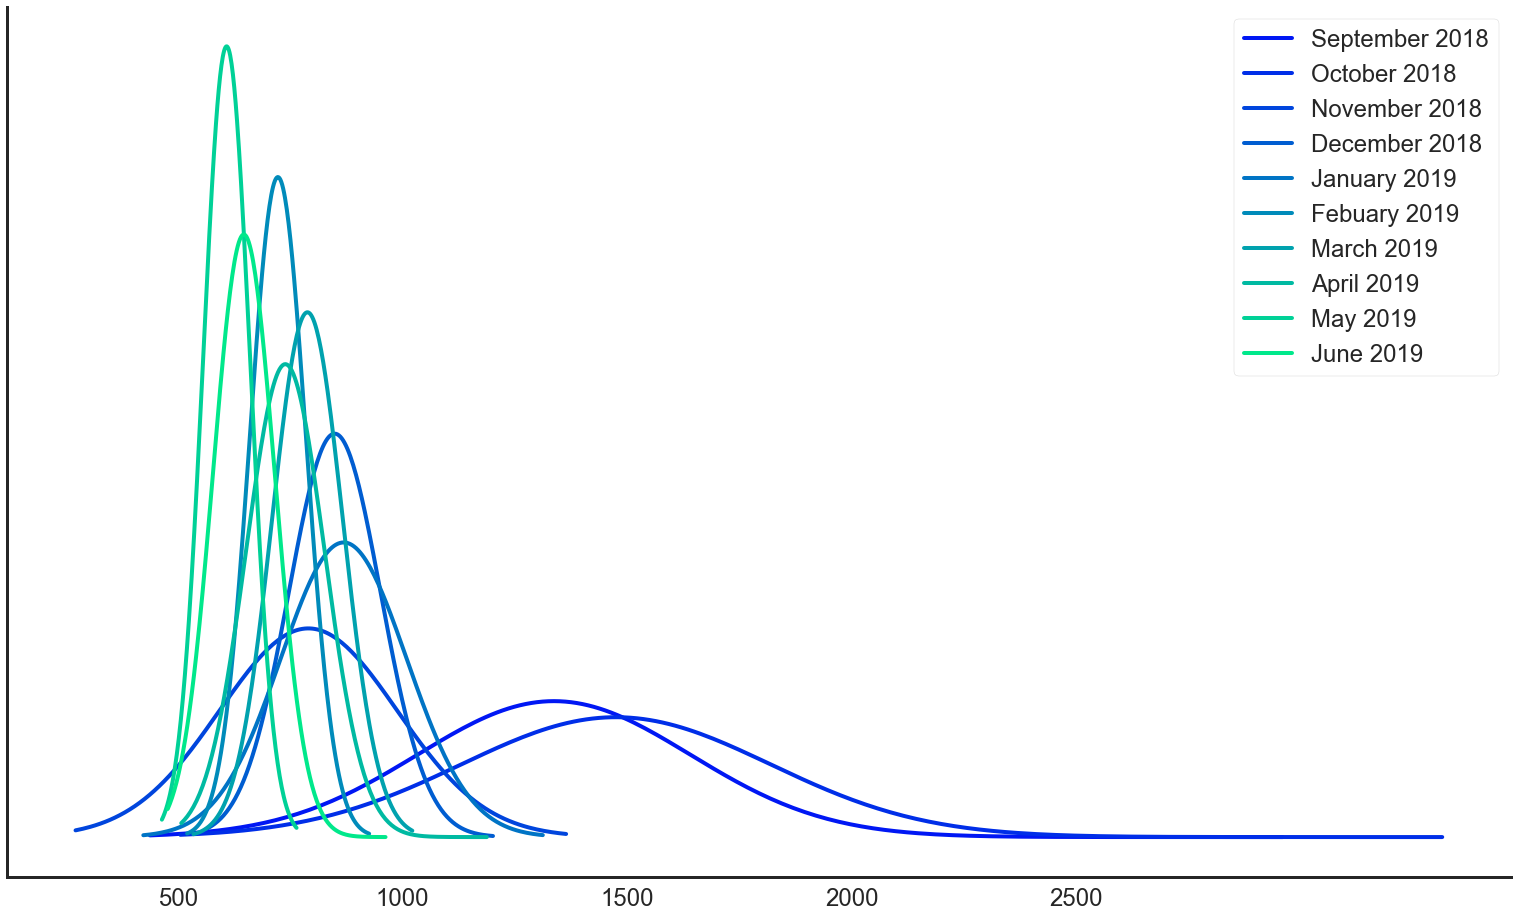

In [101]:
fig, ax = plt.subplots(1, figsize=(24, 16))
plt.style.use('seaborn-poster')
sns.despine()
sns.set_style("white")

rollup = (
 pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
)

for color, month_num, month in zip(
    sns.color_palette("winter", n_colors=10), 
    [9, 10, 11, 12, 1, 2, 3, 4, 5, 6],
    ['September 2018', 'October 2018', 'November 2018', 'December 2018', 'January 2019', 'Febuary 2019',
     'March 2019', 'April 2019', 'May 2019', 'June 2019'
    ]
):
    sns.distplot(
        rollup.pipe(lambda srs: srs[(pd.Series(srs.index).dt.month == month_num).values]),
        fit=norm, kde=False, hist=False, label=month, fit_kws={'color': color, 'linewidth': 4},
        ax=ax
    )

ax.legend(prop={'size': 24})
# ax.set_title("Trash Distribution Month over Month")
ax.set_yticks([])
ax.set_xticklabels([0, 500, 1000, 1500, 2000, 2500], fontdict={'fontsize': 24})



## Visual idea four: outliers

We start with an idea of the overall distribution.

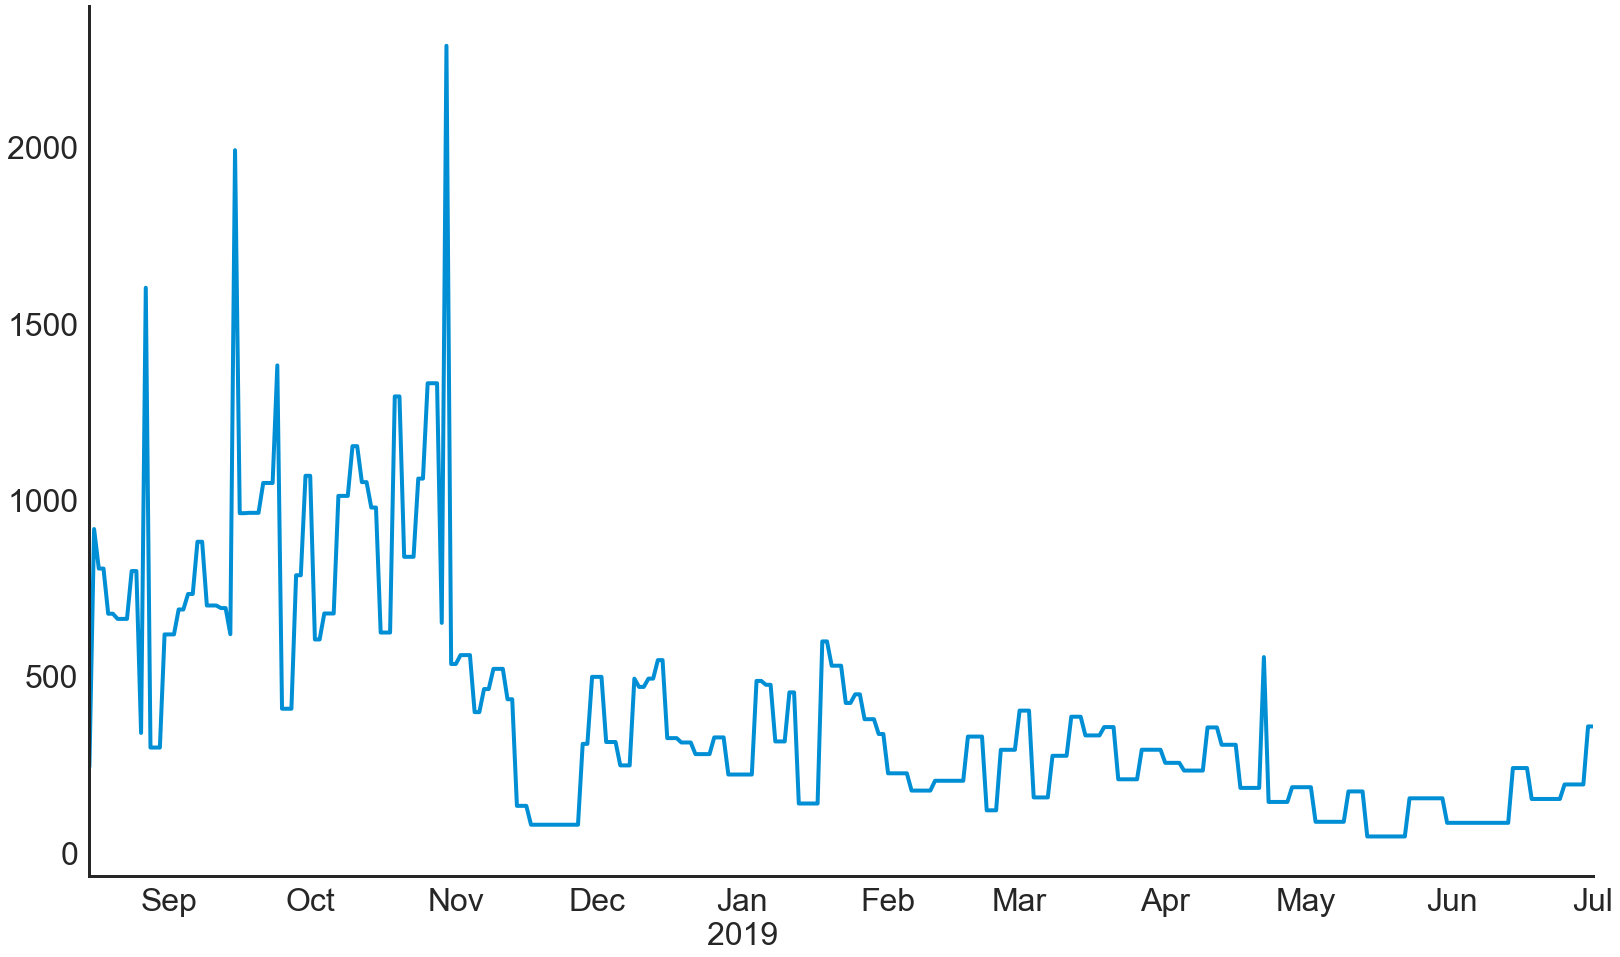

In [86]:
(pd.DataFrame(trash_all_volumes_by_day)
 .iloc[1:]
 .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
 .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
 .resample('D')
 .fillna(method='bfill')
 .rename_axis(None)
 .plot.line(linewidth=4, figsize=(24, 16), fontsize=32)
)
sns.despine()

This allows us to point out the strongest outliers that we understand:

* Halloween
* Week of Thanksgiving
* The Fires
* The Heat Wave

As well as the strongest outliers we do not understand:

* August 27
* September 23
* That one week in May

We explored all of these up close in the previous section, in the process of trying to isolate effects on the mean distribution of trash over time, so there's nothing more to say about them now; this section of the article will mostly be about the words.

## The story thus far

* The geography of Polk Street; the left and right sides of the street are very different, both volumetrically and in distribution.
* There has been a very fundamental change in trash distribution on Polk, as a result of outreach, visibility, and the "clean street" effect.
* A discussion of outliers: things that show up, things that don't.

## Visual idea five: trash categories

Recall the categorical changeover from `bottlesCans` to `plastic` we looked at in 02. We still need to change this over b/c we didn't clean this up earlier in this notebook.

In [65]:
trash = trash.assign(type=trash['type'].map(lambda v: v if v != 'bottlesCans' else 'plastic'))

Let's generate a cleaned up version of our earlier plot that's more suitable for publication.

In [66]:
categorical_trash_drop_rates = (trash
 .set_index('time')
 .assign(n=0)
 .groupby(['type', pd.Grouper(freq='D')])
 .count()
 .n
 .reset_index()
 .set_index('time')
 .pipe(lambda df: df.iloc[1:].assign(delta_days=(df.index[1:] - df.index[:-1]).days))
 .pipe(lambda df: df.assign(est_drop_rate=df.apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')))
 .groupby('type')
 .resample('D')
 .fillna(method='bfill')
 .est_drop_rate
)

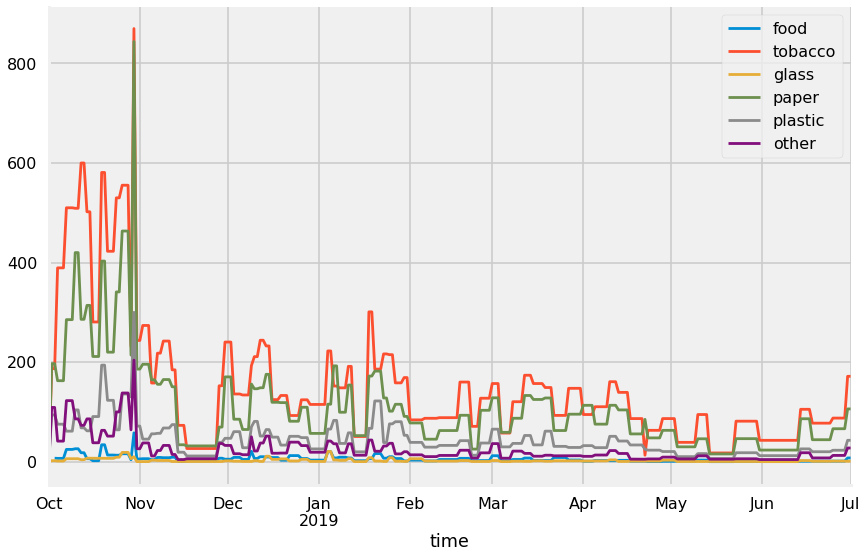

In [67]:
categorical_trash_drop_rates['food'].rename('food').plot.line()
categorical_trash_drop_rates['tobacco'].rename('tobacco').plot.line()
categorical_trash_drop_rates['glass'].rename('glass').plot.line()
categorical_trash_drop_rates['paper'].rename('paper').plot.line()
categorical_trash_drop_rates['plastic'].rename('plastic').plot.line()
categorical_trash_drop_rates['other'].rename('other').plot.line()
sns.despine()
plt.legend()

This plot is too noisy. We could generate a stacked plot, but really I think the point we want to make is that no matter the day of the year or overall volume, the makeup of trash on the street is (basically) always the same.

In [68]:
# (pd.DataFrame(trash_all_volumes_by_day)
#  .iloc[1:]
#  .assign(delta_days=(trash_all_volumes_by_day.index[1:] - trash_all_volumes_by_day.index[:-1]).days)
#  .apply(lambda srs: srs['n'] / srs['delta_days'], axis='columns')
#  .resample('D')
#  .fillna(method='bfill')
# )

In [69]:
all_trash_drop_rates = categorical_trash_drop_rates.groupby('time').sum().iloc[2:]
cat_trash_perc = (categorical_trash_drop_rates / all_trash_drop_rates)

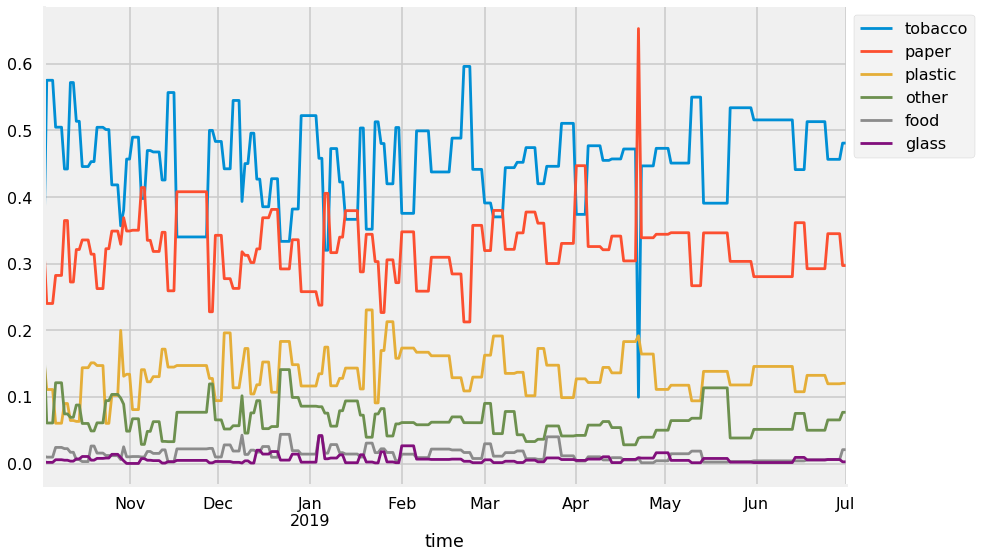

In [70]:
cat_trash_perc.unstack('type').iloc[2:].loc[:, ['tobacco', 'paper', 'plastic', 'other', 'food', 'glass']]\
    .plot.line()
sns.despine()
plt.legend(bbox_to_anchor=(1, 1))

This plot is good for two things:

* Making the point that the distribution of trash on the street is about the same throughout the year.
* Pointing out occassional rare events, like e.g. that day in April.

With these points made we can normal-distribute the categories:

In [71]:
for color, month_num, month in zip(
    sns.color_palette("winter", n_colors=10), 
    [9, 10, 11, 12, 1, 2, 3, 4, 5, 6],
    ['September 2018', 'October 2018', 'November 2018', 'December 2018', 'January 2019', 'Febuary 2019',
     'March 2019', 'April 2019', 'May 2019', 'June 2019'
    ]
):
    sns.distplot(
        rollup.pipe(lambda srs: srs[(pd.Series(srs.index).dt.month == month_num).values]),
        fit=norm, kde=False, hist=False, label=month, fit_kws={'color': color},
        ax=ax
    )


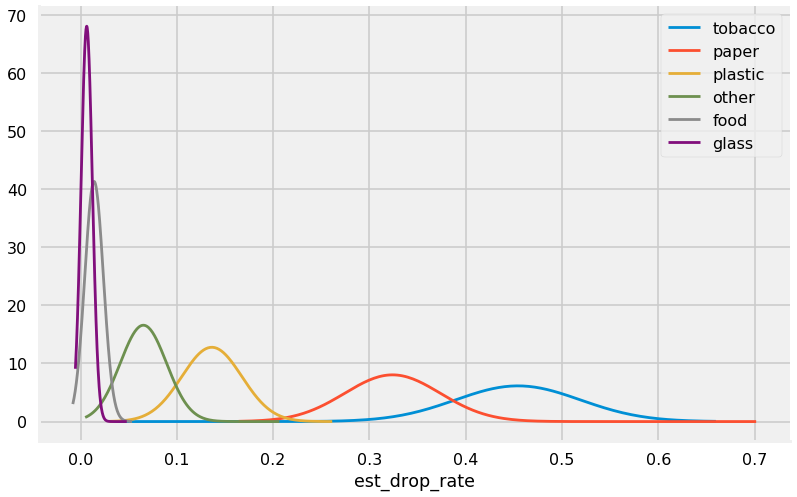

In [72]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.despine()

for color, _type in zip(
    sns.color_palette(None, n_colors=6),
    ['tobacco', 'paper', 'plastic', 'other', 'food', 'glass']
):
    sns.distplot(
        cat_trash_perc[_type].iloc[2:],
        fit=norm, kde=False, hist=False, label=_type, fit_kws={'color': color},
        ax=ax
    )

ax.legend()

This doesn't feel like the best way of communicating this. After ditzing around with a couple of concepts, I think it'd be best to extend the existing linegraph with labels, and use that.

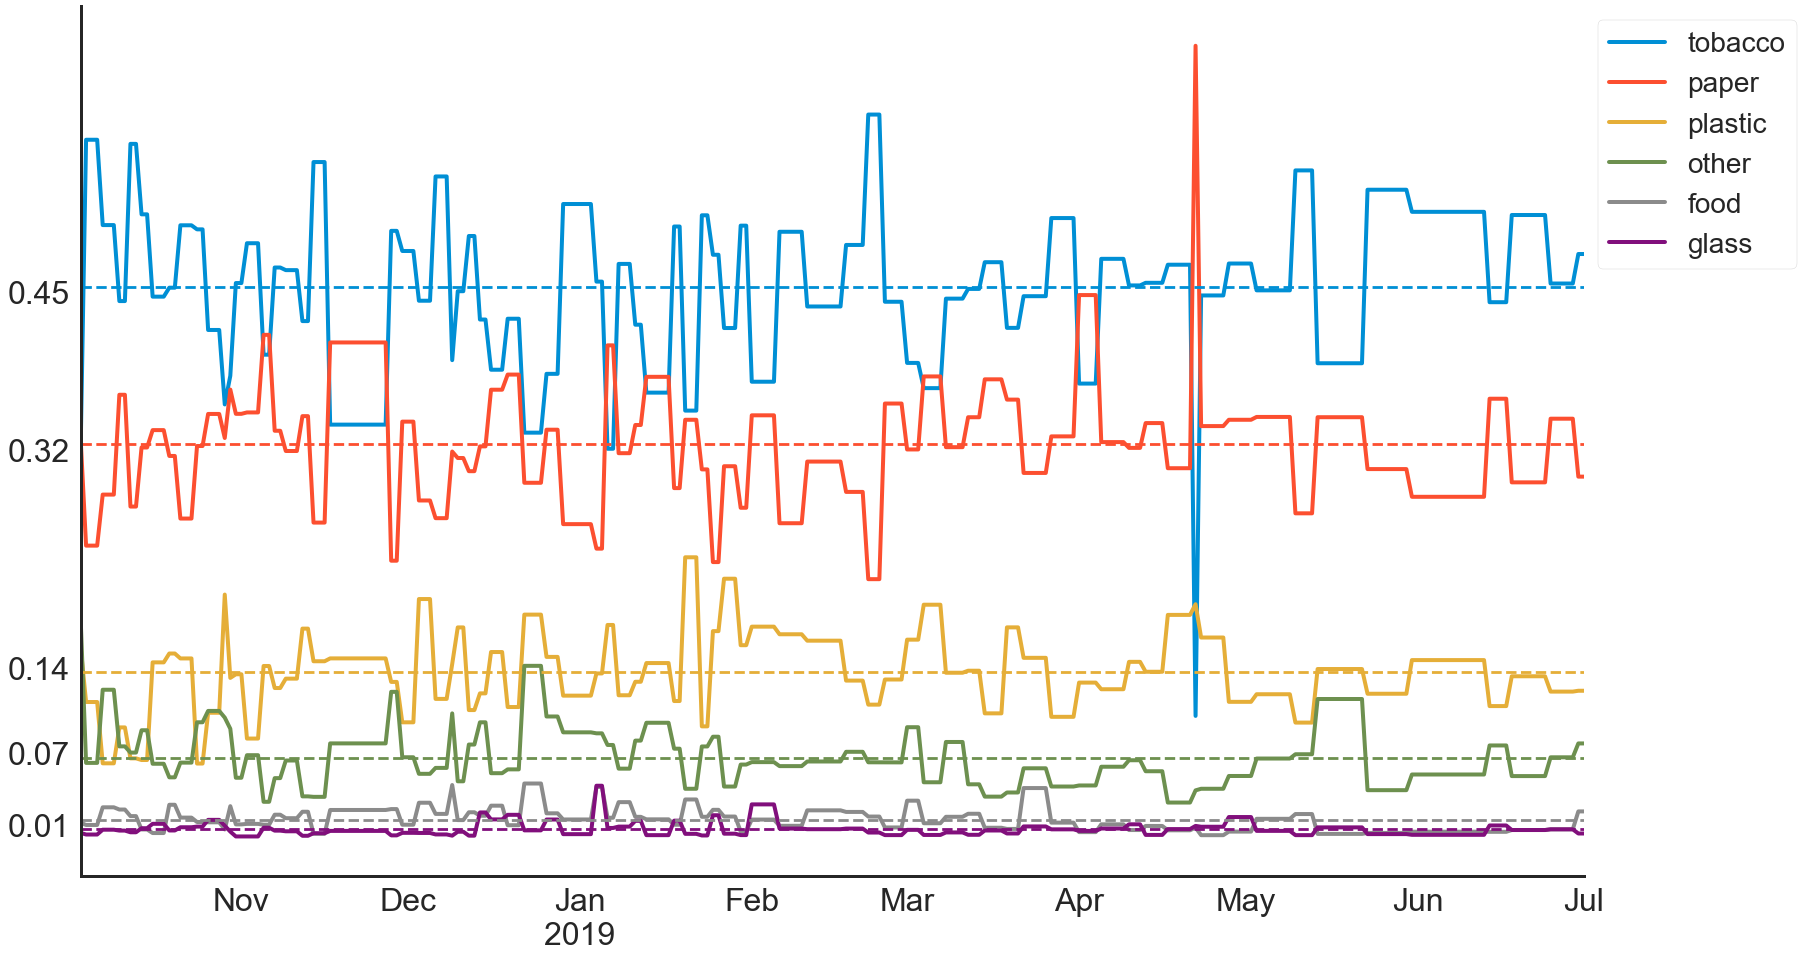

In [104]:
fig, ax = plt.subplots(1, figsize=(24, 16))

sns.set_style('white')
ax = cat_trash_perc.unstack('type').iloc[2:].loc[:, ['tobacco', 'paper', 'plastic', 'other', 'food', 'glass']]\
    .plot.line(linewidth=4, ax=ax, fontsize=32)
avgs = cat_trash_perc.groupby('type').mean()[['tobacco', 'paper', 'plastic', 'other', 'food', 'glass']]

labels = []
for ((_type, perc), color) in zip(avgs.iteritems(), sns.color_palette(None, 6)):
    ax.axhline(perc, linestyle='--', color=color)
    labels.append(perc)

sns.despine()
ax.set_yticks(np.round(labels, 2)[:-1])
ax.set_xlabel(None)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 28})

That about covers all of the non-geospatial bases for this dataset. Let's break here, and swap to working on geospatial analysis in a new notebook, as this one is getting very long.